# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В нашем распоряжении набор фотографий людей с указанием возраста.

Цель исследования: Построить модель, которая по фотографии определит приблизительный возраст человека. MAE <= 8.

Ход исследования:
1. Загрузка данных
2. Исследовательский анализ данных
3. Обучение модели
4. Анализ обученной модели
5. Общий вывод 

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

## Исследовательский анализ данных

### Обзор классов

In [2]:
# загрузка файла с классами
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# первые строки датафрейма
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# описание датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# описание столбца с классами
df.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


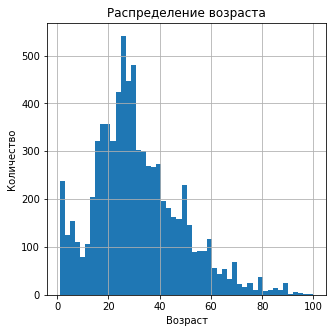

In [6]:
# график "распределение возраста"
df['real_age'].hist(bins=50, figsize=(5,5))
plt.title('Распределение возраста')
plt.ylabel('Количество')
plt.xlabel('Возраст')
plt.show()

**Вывод**: Датафрейм имеет 7591 строк. Основная часть целевого признака (возраст людей) в диапазоне от 15 до 50.Минимальное значение: 1, а максимальное: 100. График имеет длинный хвост справа, поэтому среднее немного смещено в ту же сторону. 

Наличие длинного хвоста говорит о наличии выбросов и недостатке данных при возрасте большем 75. Это может ухудшить качество модели при прогнозировании в этом диапазоне.

### Обзор признаков

In [7]:
# загрузчик изображений. С помощью flow_from_dataframe соотносим изображения с классами
datagen = ImageDataGenerator(rescale=1/255)

datagen_flow = datagen.flow_from_dataframe(dataframe=df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',                                     
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=96)

Found 7591 validated image filenames.


Возраст: 18


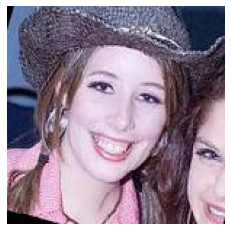

Возраст: 22


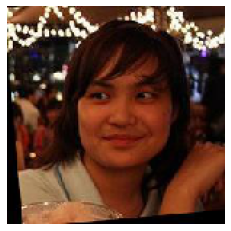

Возраст: 82


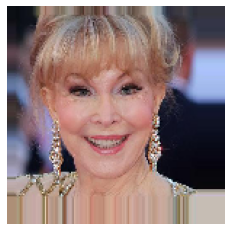

Возраст: 7


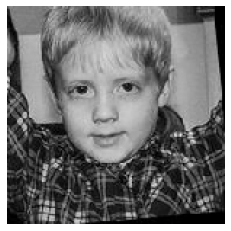

Возраст: 68


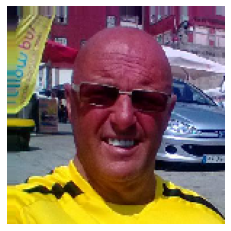

Возраст: 36


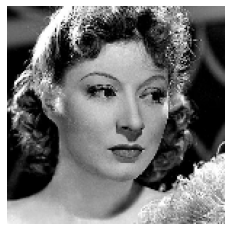

Возраст: 24


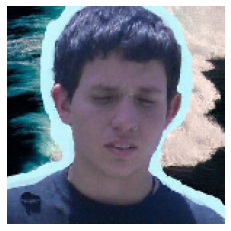

Возраст: 22


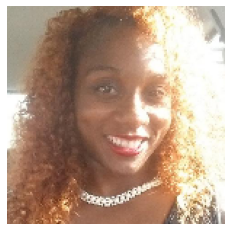

Возраст: 36


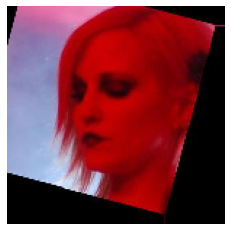

Возраст: 39


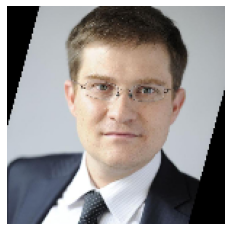

In [8]:
# выведем первые 10 изображений и возраст
img, age = next(datagen_flow)
for i in range(10):
    print('Возраст:', age[i])
    plt.imshow(img[i])
    plt.axis('off')
    plt.show()

**Вывод:** Датасет состоит из 7591 фотографий людей. Мы объедили файл с метками и фотографии по названию файлов и дальше вывели рандомные 10 изображений набора данных и возраст. Визуально можем увидеть соответствие возраста с людьми на фото. Также видно, что фото уже аугментированы (фотографии повернуты, сдвинуты, имеются черно белые и размеченные фотографии) это увеличит качество модели.

## Обучение модели

Разделим выгрузку на тренировочную и тестовую и обучим сверточную нейронную сеть.
Применяем архитектуру ResNet50 + добавляем GlobalAveragePooling2D и Dense — полносвязный слой для классификации с одним нейроном и функцией активации **relu**. Для обучения используем алгоритм Adam со скоростью обучения 0.0001. Обучающий набор отражаем по горизонтали.

Функция потерь: MSE. 

Основная метрика:MAE

Количество эпох: 20

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=pd.read_csv(path+'labels.csv'),
    directory= path + 'final_files/',
    x_col='file_name',
    y_col='real_age',                                     
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=96)
    return train_datagen_flow


def load_test(path):
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=pd.read_csv(path+'labels.csv'),
    directory= path + 'final_files/',
    x_col='file_name',
    y_col='real_age',                                     
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=96)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001) 

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 


```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2023-10-05 05:21:50.091870: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-05 05:21:51.608884: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 72s - loss: 203.6103 - mae: 10.3315 - val_loss: 489.1894 - val_mae: 16.8032
Epoch 2/20
356/356 - 39s - loss: 83.4852 - mae: 6.9325 - val_loss: 140.1986 - val_mae: 9.2455
Epoch 3/20
356/356 - 40s - loss: 57.1602 - mae: 5.7466 - val_loss: 86.4061 - val_mae: 6.7717
Epoch 4/20
356/356 - 39s - loss: 41.6901 - mae: 4.9326 - val_loss: 73.9224 - val_mae: 6.4926
Epoch 5/20
356/356 - 39s - loss: 31.5251 - mae: 4.2956 - val_loss: 68.6602 - val_mae: 6.1911
Epoch 6/20
356/356 - 39s - loss: 24.5065 - mae: 3.7754 - val_loss: 80.8375 - val_mae: 6.7679
Epoch 7/20
356/356 - 39s - loss: 19.0450 - mae: 3.3444 - val_loss: 92.8005 - val_mae: 7.0809
Epoch 8/20
356/356 - 40s - loss: 17.8846 - mae: 3.1941 - val_loss: 71.3302 - val_mae: 6.4312
Epoch 9/20
356/356 - 39s - loss: 15.3805 - mae: 2.9826 - val_loss: 68.4220 - val_mae: 6.2967
Epoch 10/20
356/356 - 40s - loss: 13.5016 - mae: 2.7742 - val_loss: 65.6729 - val_mae: 5.9757
Epoch 11/20
356/356 - 39s - loss: 12.5787 - mae: 2.7022 - val_loss: 76.8748 - val_mae: 6.7149
Epoch 12/20
356/356 - 39s - loss: 11.6721 - mae: 2.6154 - val_loss: 68.0152 - val_mae: 6.1445
Epoch 13/20
356/356 - 39s - loss: 11.7044 - mae: 2.6011 - val_loss: 65.0551 - val_mae: 6.0113
Epoch 14/20
356/356 - 39s - loss: 11.5368 - mae: 2.5795 - val_loss: 67.1264 - val_mae: 6.2208
Epoch 15/20
356/356 - 39s - loss: 10.5553 - mae: 2.4684 - val_loss: 65.0960 - val_mae: 5.9527
Epoch 16/20
Epoch 17/20
356/356 - 39s - loss: 10.2432 - mae: 2.4418 - val_loss: 60.3236 - val_mae: 5.7019
356/356 - 40s - loss: 10.0515 - mae: 2.3943 - val_loss: 63.8468 - val_mae: 5.8943
Epoch 18/20
356/356 - 39s - loss: 10.6052 - mae: 2.4783 - val_loss: 59.4316 - val_mae: 5.6723
Epoch 19/20
356/356 - 39s - loss: 10.1931 - mae: 2.4306 - val_loss: 60.7642 - val_mae: 5.6828
Epoch 20/20
356/356 - 39s - loss: 9.6618 - mae: 2.3549 - val_loss: 71.4988 - val_mae: 6.2908
119/119 - 10s - loss: 71.4988 - mae: 6.2908
Test MAE: 6.2908

```

**Вывод:** Значение MAE на тестовой выборке 6.2908

## Анализ обученной модели

Значение MAE на тестовой выборке 6.2908 (результат <=8 значит цель выполнена и можем брать модель в производство). При определении возраста человека такая разница невелика для людей находящихся в диапазоне 20-50 лет, т.е. в том возрасте где тело не проходит резких трансформаций.


В процессе обучения видим, что модель сильно переобучается на тренировочной выборке. Обычно нейронные сети с большим числом слоёв сильно переобучаются, что не мешает при достаточном количестве эпох и определенной скорости обучения достичь нужного значения метрики на тестовой выборке.
При таких параметрах, для ускорения обучения количество эпох можно уменьшить.

## Общий вывод

В рамках данного исследования нам нужно было построить модель сверточной нейронной сети для сетевого супермаркет «Хлеб-Соль». Модель должна стать ключевым элементом системы компьютерного зрения для определения возраста покупателей в прикассовой зоне. Компания с помощью этого планирует разбивать клиентов на возрастные группы и делать индивидуальные предложения для каждой группы. Так же это поможет контролировать добросовестность кассиров при продаже алкоголя.

Нам были доступны 7591 фотографий и файл с таким же количеством меток. Диапазон классов: [1:100].
Анализ классов показал, что целевой признак в основном находится в диапазоне от 15 до 50 лет. 
При анализе фотографий выявили что в наборе данных присутствуют аугментированные изображения, что положительно скажется на обучении модели.

Мы подготовили и обучили сверточную нейронную сеть со следующими параметрами:
- Слои: ResNet50 + GlobalAveragePooling2D + Dense (1 нейрон с активатором relu). 
- optimizer='adam'
- learning_rate = 0.0001.
- loss = 'mean_squared_error'.
- metrics = 'mae'
- epochs = 20

В результате цель была выполнена. Данная модель показала значение MAE на тестовой выборке 6.2908. Она может отправляться в производство.

Дальнейшие рекомендации:
- Нейронные сети с большим числом слоёв сильно переобучаются - это не является препятствием
- Модель можно улучшить добавив в набор еще фотографии людей